In [1]:
from scipy.interpolate import interp1d
from specutils import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from specutils.manipulation import FluxConservingResampler
from pybaselines import whittaker
import numpy as np
import matplotlib.pyplot as plt
import pickle
import astropy.units as u
from astropy.io import fits
import scipy.constants as cst
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.cosmology import Planck15 as cosmo
from functools import partial
import powspec
import pandas as pd
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.modeling.models import Gaussian1D
from scipy.interpolate import interp1d
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
from set_k import make_bintab

noise_model_HF = pd.read_csv('tim_sw_loading.tsv', sep='\t')
noise_model_LF = pd.read_csv('tim_lw_loading.tsv', sep='\t')

/tmp/ipykernel_55757/4207497118.py:20: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e9)/1e-6


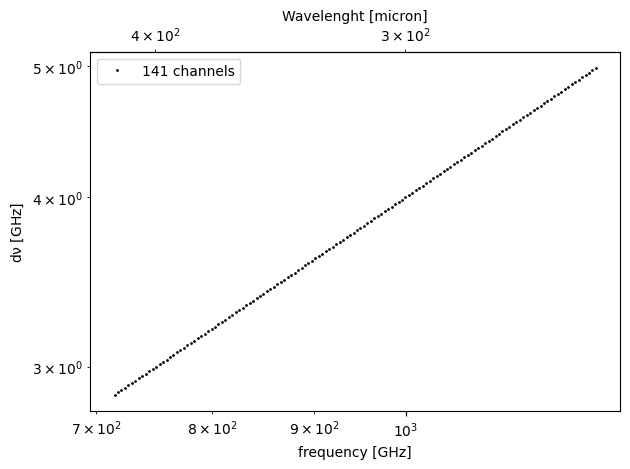

In [26]:
# Define the wavelength range in microns
freq_min = 715  # in GHz
freq_max = 1250  # in GHz
R = 250  # Spectral resolution
# Initialize the array
freqs = [freq_min]
# Generate wavelengths array
while freqs[-1] < freq_max:
    delta_lambda = freqs[-1] / R
    next_lambda  = freqs[-1] + delta_lambda
    freqs.append(next_lambda)
# Convert to numpy array for convenience
freqs = np.array(freqs)
channel_widths = np.diff(freqs)

fig, ax = plt.subplots()
ax.loglog(freqs[:-1], channel_widths, 'ok', markersize=1, label=f'{len(freqs)}'+' channels')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('d$\\rm \\nu$ [GHz]')
def w_to_f(x): return cst.c/(x*1e9)/1e-6
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Wavelenght [micron]')
ax.legend()
plt.tight_layout()



In [3]:
zcii_tim = 1900.53690000 / (freqs[::-1]) -1

#Spatial deep
res = 25 #arcsec
field_size_ra =  0.2 
field_size_dec = 1 
field_size = field_size_dec * field_size_ra

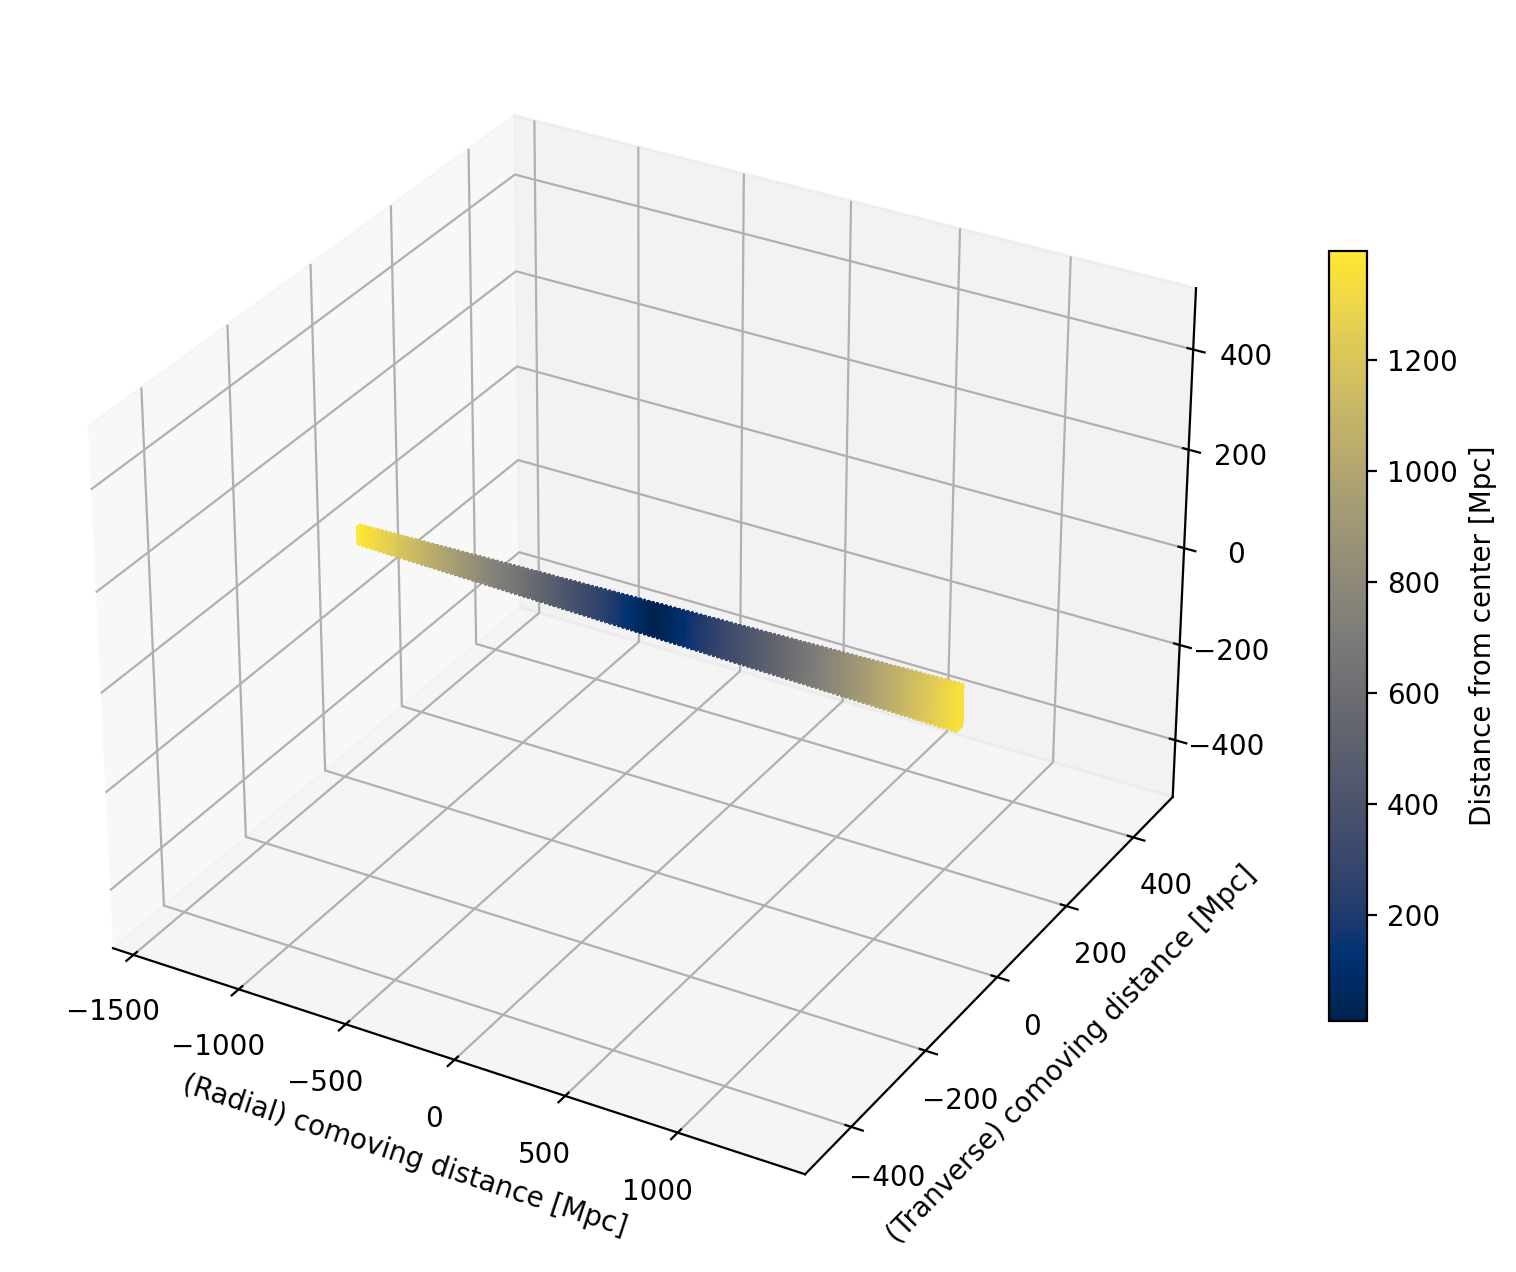

In [4]:
Dc_center = cosmo.comoving_distance(zcii_tim).value
Dc_centered = Dc_center - Dc_center.mean()

ragrid= np.arange(0,field_size_ra,(res*u.arcsec).to(u.deg).value)
decgrid= np.arange(0,field_size_dec,(res*u.arcsec).to(u.deg).value)

ra_center = np.mean(ragrid)
dec_center = np.mean(decgrid)

#all the coordinates will be in comoving units
size_x = Dc_center * field_size_ra * (np.pi/180) * np.cos(np.pi/180*dec_center)
size_y = Dc_center * field_size_dec * (np.pi/180) 

#compute the coordinates in the cube
ys = Dc_center * ( ragrid[:, np.newaxis]  - ra_center)  * (np.pi/180) * np.cos(np.pi/180*ragrid[:, np.newaxis])
xs = Dc_center * ( decgrid[:, np.newaxis] - dec_center) * (np.pi/180)

Z_rad = []
for i in range(len(Dc_center)):
    X, Y = np.meshgrid(ys[:,i], xs[:,i])     # Create a grid
    Z_rad.append(np.sqrt(Y**2+X**2))
Z_rad = np.asarray(Z_rad)
Z = np.sqrt(Z_rad**2 + Dc_centered[:, None, None]**2)

cube =        np.zeros((len(zcii_tim), len(ragrid), len(decgrid), 3))
cube_sphere = np.zeros((len(zcii_tim), len(ragrid), len(decgrid), 3))

for i in range(len(zcii_tim)):
    for j in range(len(ragrid)):
        for k in range(len(decgrid)):
            cube[i,j,k,0] = Dc_centered[i]
            cube[i,j,k,1] = ys[j, i]
            cube[i,j,k,2] = xs[k, i]

ax = plt.figure(figsize=(8,8), dpi=200).add_subplot(projection='3d')
sc = ax.scatter(cube[:,:,:,0].flatten(), cube[:,:,:,1].flatten(), cube[:,:,:,2].flatten(), marker='.', s=0.1, c=Z.ravel(), cmap='cividis')
ax.set_xlabel("(Radial) comoving distance [Mpc]")
ax.set_ylabel("(Tranverse) comoving distance [Mpc]")
colorbar = plt.colorbar(sc, ax=ax, shrink=0.5)
colorbar.set_label("Distance from center [Mpc]")
ax.set_ylim([-500, 500])  # Example limits for y-axis
ax.set_zlim([-500, 500])  # Example limits for z-axis
plt.tight_layout()

#----------------------
'''
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3,6))
ax1.imshow(Z[0,:,:], origin='lower'); im = ax2.imshow(Z[-1,:,:], origin='lower'); 
cbar = fig.colorbar(im, ax=ax2, pad=0.2)

ax1.plot(( Z_rad.shape[2]/2, Z_rad.shape[2]/2), (0, Z_rad.shape[1]) ,'r')
ax1.plot(( 0, Z_rad.shape[2]), (Z.shape[1]/2, Z_rad.shape[1]/2) ,'b')
'''
#--------------------------------------
res_radial = np.diff(Dc_center)

Dc_quarters = np.array_split(Dc_center, 4)
zquarters = np.array_split(zcii_tim, 4)
radial_size = []
z_center = []
for quarter, z in zip(Dc_quarters,zquarters):
    radial_size.append(quarter.max()-quarter.min())
    z_center.append(z.mean())

res_transverse = []
for i in range(len(Dc_center)):
    X, Y = np.meshgrid(ys[:,i], xs[:,i])     # Create a grid
    res_transverse.append( np.diff(Y, axis = 0).mean())
res_transverse = np.asarray(res_transverse)

Z_quarters = np.array_split(Z_rad,4,axis=0)
RA_size = []
DEC_size = []
for Zquart, zquart, c in zip(Z_quarters, zquarters,  ('g', 'r',  'b', 'magenta')):
    for i in range(Zquart.shape[0]):
        RA_size.append( Zquart[i, Z.shape[1]//2, :].max())
        DEC_size.append(Zquart[i, :, Z.shape[2]//2].max())

RA_size = np.asarray(RA_size)
DEC_size = np.asarray(DEC_size)


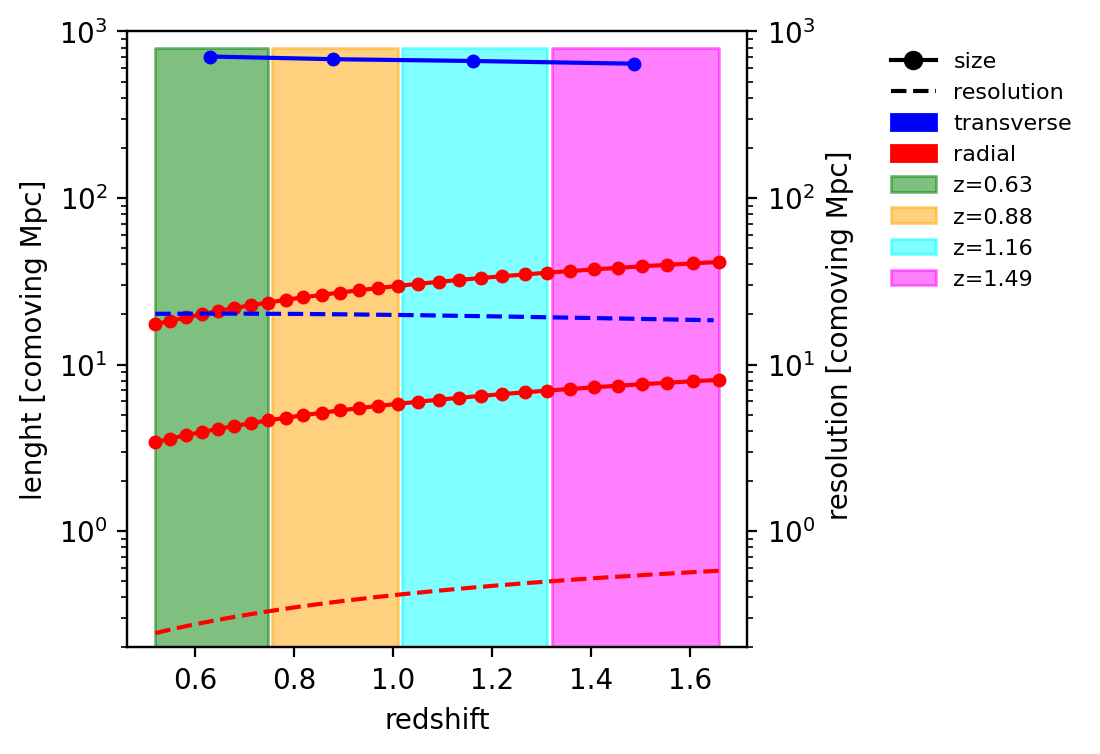

In [5]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(4,4), dpi=200) 
ax2 = ax.twinx()
patchs = []
patch = mlines.Line2D([], [], color='k', linestyle="solid" , marker='o', label='size'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k', linestyle="--",  label='resolution'); patchs.append(patch)
patch = mpatches.Patch(color='b', label='transverse', ); patchs.append(patch); 
patch = mpatches.Patch(color='r', label='radial', ); patchs.append(patch); 

ax2.plot(zcii_tim, res_transverse, 'r', ls = '--')
ax2.plot(zcii_tim[:-1], res_radial, 'b', ls = '--')
ax.plot(zcii_tim[::5], RA_size[::5], 'or',markersize=4)
ax.plot(zcii_tim[::5], DEC_size[::5], 'or',markersize=4)
ax.plot(zcii_tim[::5], RA_size[::5], 'r',)
ax.plot(zcii_tim[::5], DEC_size[::5], 'r',)
ax.plot(z_center, radial_size, 'b')
ax.plot(z_center, radial_size, 'ob', markersize=4)

ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_ylim(2e-1, 1e3)
ax2.set_ylim(2e-1, 1e3)

for i, (z,c) in enumerate(zip( zquarters,  ('g', 'orange',  'cyan', 'magenta'))): 
    patch = mpatches.Patch(color=c, label=f'z={np.round(z.mean(),2)}', alpha=0.5 ); patchs.append(patch); 
    ax.fill_between(z,0,800, color=c,alpha=0.5 )
plt.xscale('linear')
ax.set_ylabel('lenght [comoving Mpc]')
ax2.set_ylabel(' resolution [comoving Mpc]')
ax.set_xlabel('redshift')
ax.legend(handles = patchs, bbox_to_anchor=(1.2,1),loc='upper left', frameon=False, fontsize=8)

In [6]:
from set_k import *

def give_map_spatial_freq_one_axis(res, ny):
    Ys = np.arange(ny)
    M = np.zeros(ny)
    for ys, in zip(Ys):
        M[ys] = int(ys)
    w_sup = np.where(M>ny/2)
    M[w_sup] = ny - M[w_sup]
    Ky = M/ny/res
    k_map = (Ky**2)**(1/2)
    return k_map

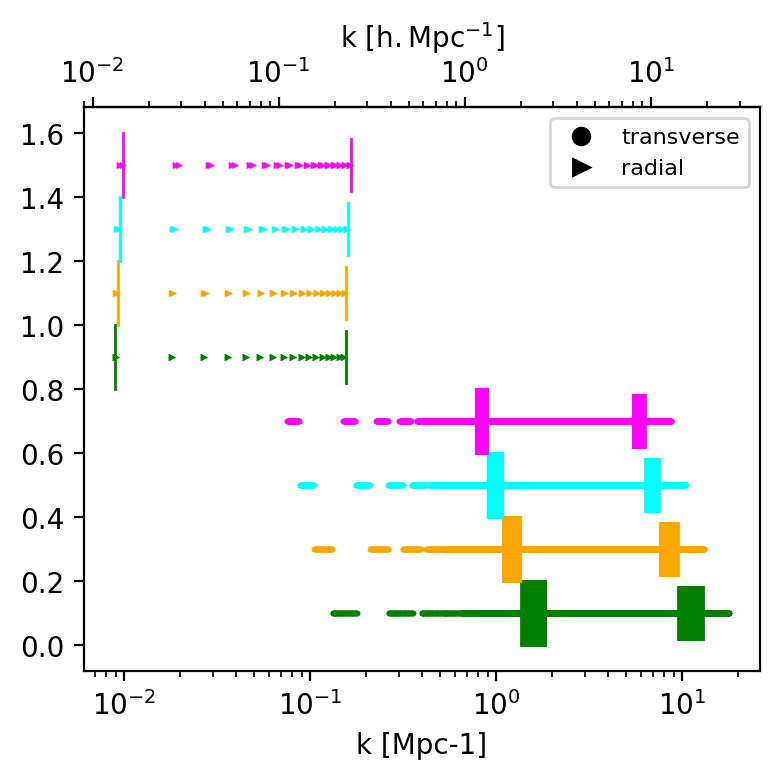

In [7]:

BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(4,4), dpi=200) 
patchs = []

Z_rad_quarters = np.array_split(Z_rad, 4,axis=0)
res_transverse_quarters = np.array_split(res_transverse, 4,axis=0)
size_quarters = np.array_split(RA_size, 4,axis=0)
res_radial_quarters = np.array_split(res_radial,4,axis=0)

for i, (z,Zrad,res_quarter, sizequarter, resrad, c) in enumerate(zip( zquarters, Z_rad_quarters,res_transverse_quarters, size_quarters, res_radial_quarters, ('g', 'orange',  'cyan', 'magenta'))): 
    for j in range(Zrad.shape[0]):
        res = res_quarter[j]
        lenght = sizequarter[j]
        y= 0.1 + 0.2*(i)
        kmap = give_map_spatial_freq(res*u.rad, Z.shape[1], Z.shape[2])
        ax.plot(2*np.pi*kmap.flatten(), y*np.ones(len(kmap.flatten())), 'o', markersize=1, c=c)
        ax.plot((np.pi / res,  np.pi / res), (y-0.08,y+0.08), c=c,lw=1)
        ax.plot((2 * np.pi / lenght, 2 * np.pi / lenght), (y-0.1,y+0.1), c=c,lw=1)\
    
    resz = resrad.mean()
    kz = 2*np.pi*give_map_spatial_freq_one_axis(resrad, len(resrad))
    y+=0.8
    radial_lenght = radial_size[i]
    ax.plot(kz, y*np.ones(len(kz)), '>', c=c, markersize=1)
    ax.plot((2 * np.pi / radial_lenght, 2 * np.pi / radial_lenght), (y-0.1,y+0.1), c=c,lw=1)
    ax.plot((np.pi / resz,  np.pi / resz), (y-0.08,y+0.08), c=c,lw=1)
    
patch = mlines.Line2D([], [], color='k', linestyle='None', marker = 'o',label='transverse'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k', linestyle='None', marker = '>',label='radial'); patchs.append(patch)

ax.set_xscale('log')
ax.set_xlabel('k [Mpc-1]')

def g(h, x): return x/h
G = partial(g, cosmo.h)
secax = ax.secondary_xaxis("top", functions=(G,G))
secax.set_xlabel('k [$\\rm h.Mpc^{-1}$]')
#patch = mlines.Line2D([], [], color='k', linestyle='solid', label='at high-z'); patchs.append(patch)
ax.legend(handles = patchs, loc='upper right',  fontsize=8)#bbox_to_anchor=(1.5, 1),
fig.tight_layout()

/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


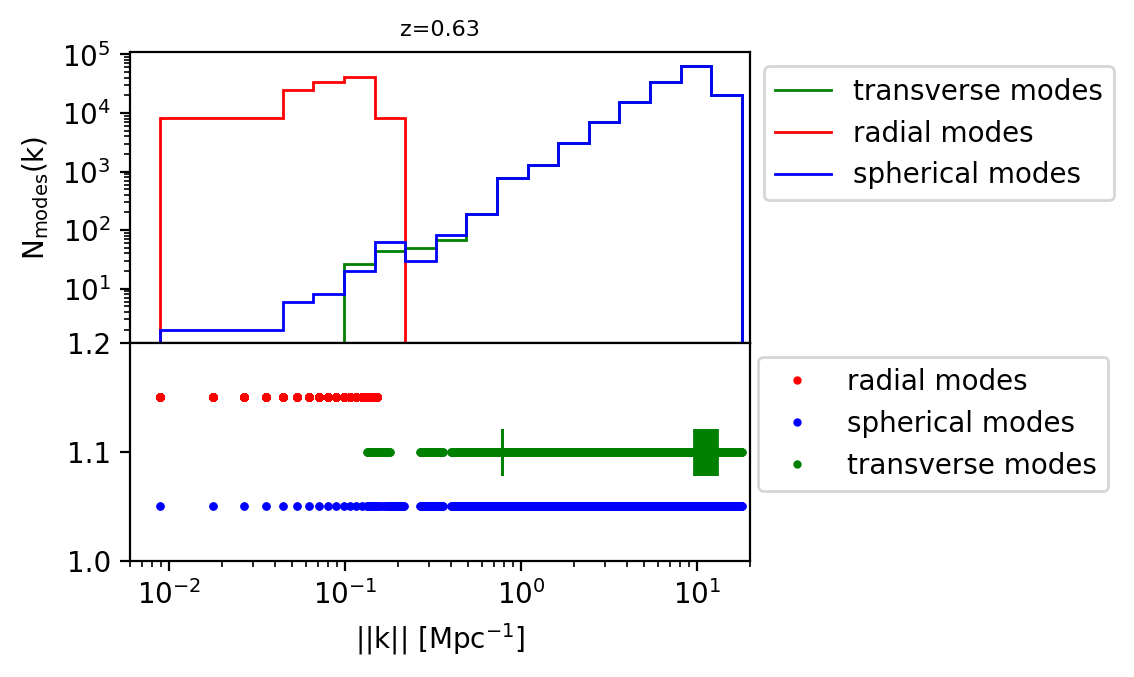

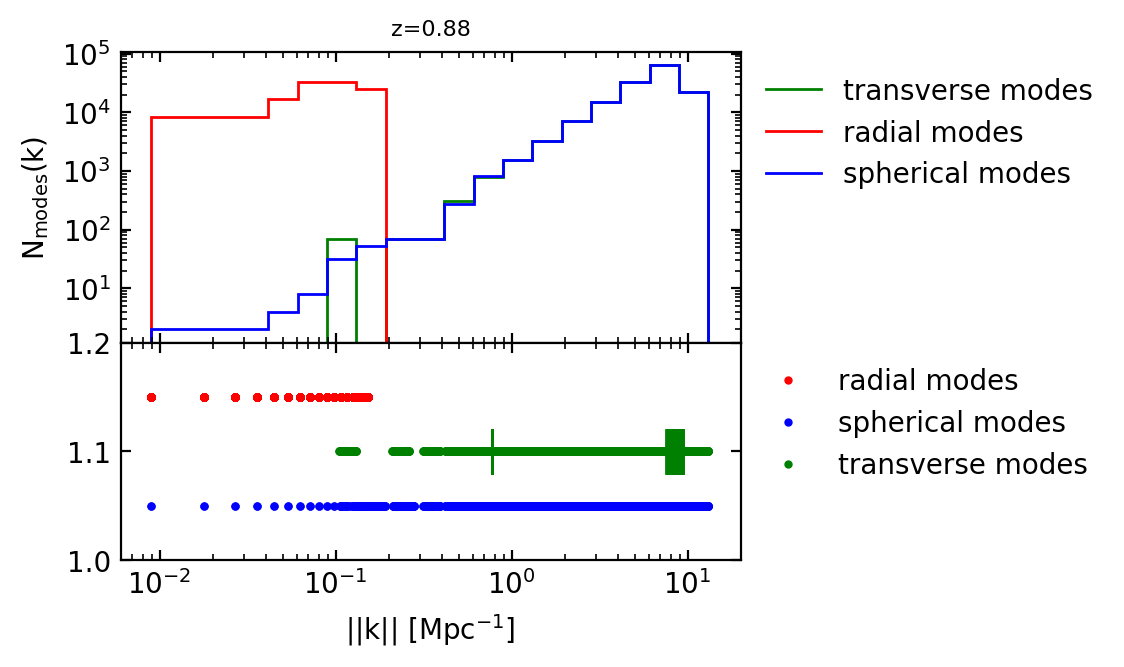

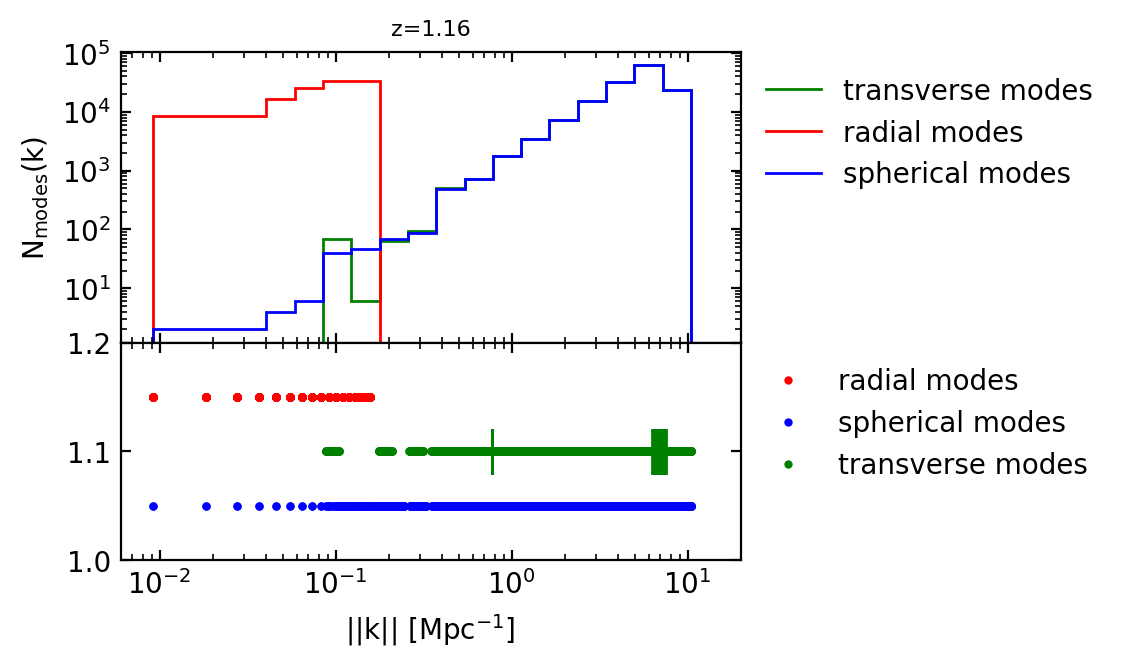

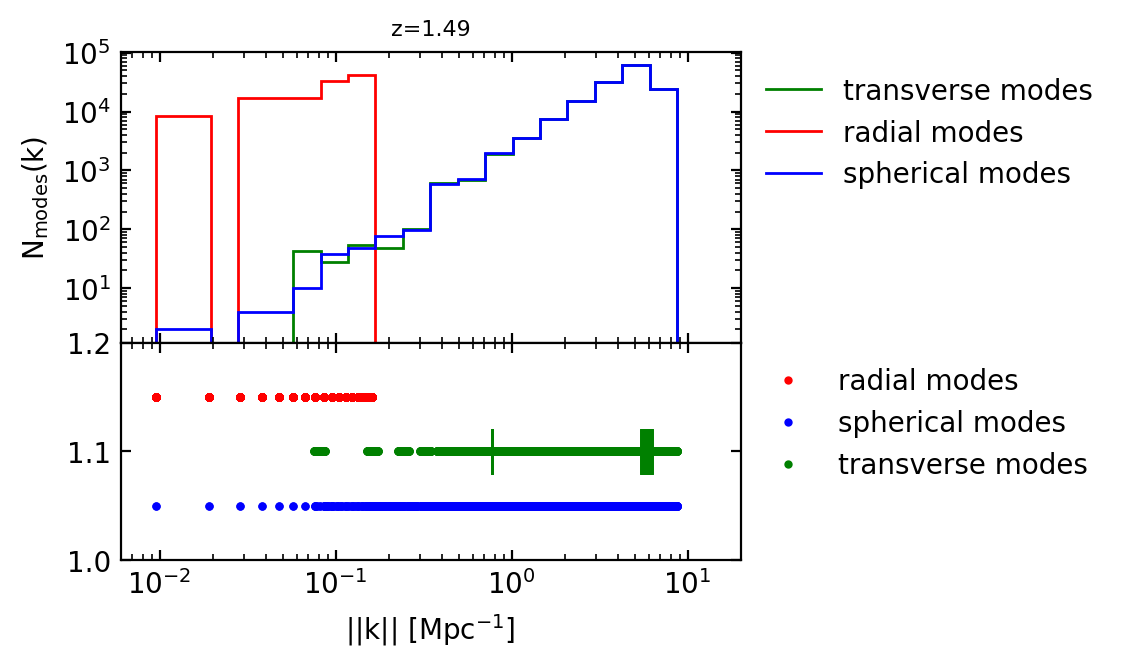

In [10]:

for i, (z,Zrad,res_quarter, sizequarter, resrad, c) in enumerate(zip( zquarters, Z_rad_quarters,res_transverse_quarters, size_quarters, res_radial_quarters, ('g', 'orange',  'cyan', 'magenta'))): 
    BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
    fig, (ax, viz) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(4, 3.3), dpi = 200)

    Kmaps = []
    
    for j in range(35):
        res = res_quarter[j]
        kmap = 2*np.pi*give_map_spatial_freq(res*u.rad, Z.shape[1], Z.shape[2])
        Kmaps.append(kmap)
        viz.plot((np.pi / res,  np.pi / res), (1.1-0.02,1.1+0.02), c='g',lw=1)
        viz.plot((2 * np.pi / lenght, 2 * np.pi / lenght),(1.1-0.02,1.1+0.02), c='g',lw=1)

    Kmaps = np.asarray(Kmaps)
    resz = resrad.mean()
    kz = 2*np.pi*give_map_spatial_freq_one_axis(resz, len(resrad))


    kz_arr = np.zeros(np.asarray(Kmaps).shape)
    kz_arr[:,:,:] = kz[:,np.newaxis, np.newaxis]
    k = np.sqrt(np.asarray(Kmaps)**2+kz[:,np.newaxis, np.newaxis]**2)/u.Mpc
    #Setting the binning of the k map
    k_binsnp = np.logspace(np.log10(k[k>0].min().value), np.log10(k.max().value), 20)

    nmodes, kbins = np.histogram(np.asarray(Kmaps).flatten(), bins = k_binsnp)
    ax.stairs(nmodes,k_binsnp, color='g', label='transverse modes')
    nmodes, kbins = np.histogram(np.asarray(kz_arr).flatten(), bins = k_binsnp)
    ax.stairs(nmodes,k_binsnp, color='r', label='radial modes')
    nmodes, kbins = np.histogram(k, bins = k_binsnp/u.Mpc)
    kmean, kbins = np.histogram(k, bins = k_binsnp/u.Mpc, weights=k)
    kmean /= nmodes
    ax.stairs(nmodes,k_binsnp, color='b', label='spherical modes')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('$\\rm N_{modes}(k)$')
    ax.set_title(f'z={np.round(z.mean(),2)}',fontsize=8)
    ax.legend(bbox_to_anchor=(1, 1),)
        
    viz.loglog(kz_arr.flatten(), 1.15*np.ones(kz_arr.flatten().shape), 'or', markersize=2, label='radial modes')
    viz.loglog(k.flatten(), 1.05*np.ones(k.flatten().shape), 'ob', markersize=2, label='spherical modes')
    viz.loglog(np.asarray(Kmaps).flatten(), 1.1*np.ones(np.asarray(Kmaps).flatten().shape), 'og', markersize=2, label='transverse modes')

    viz.set_xlabel(r'$\rm ||k||$ [$\rm Mpc^{-1}$]')
    viz.set_ylim(1, 1.2)
    viz.set_yscale('linear')
    viz.legend(bbox_to_anchor=(1.6, 1),)
    viz.set_xlim(6e-3, 2e1)

    fig.subplots_adjust(hspace=0, wspace=0)
    plt.rcParams.update({'font.size': 10})
    plt.rcParams.update({'xtick.direction':'in'})
    plt.rcParams.update({'ytick.direction':'in'})
    plt.rcParams.update({'xtick.top':True})
    plt.rcParams.update({'ytick.right':True})
    plt.rcParams.update({'legend.frameon':False})


[ -0.99893645  -0.99365081  -0.97867922  -0.94343045  -0.93667922
  -0.82231349  -0.74276755  -0.76072127   0.89351696   0.87797871
   2.23529657   1.25082697   3.92295263   5.63770248   8.94563581
  13.91824339  21.16657728  36.51386162 319.75781816]
[-9.98316370e-01 -9.90114900e-01 -9.67353397e-01 -9.14809747e-01
 -8.81793940e-01 -7.92796707e-01 -8.14582275e-01 -7.05635692e-01
 -1.84564674e-01  1.50468399e+00  1.16004935e+00  8.56329342e-01
  2.55419804e+00  4.24482864e+00  6.57051965e+00  1.00438867e+01
  1.51380673e+01  2.46535285e+01  1.85302393e+02]
[ -0.99746186  -0.9852943   -0.95207326  -0.87658581  -0.83101419
  -0.65475824  -0.84690592  -0.60769355  -0.24838363   0.91656006
   0.19511707   1.10110174   1.8422816    3.36078068   5.2677411
   7.94328263  11.91564669  18.8376189  129.46825943]
[-9.96347780e-01 -9.79081726e-01             nan -9.34326543e-01
 -7.67786144e-01 -7.22311019e-01 -8.23653900e-01 -5.58249588e-01
 -2.86204915e-01  7.93998874e-01 -6.99090474e-02  1.04962

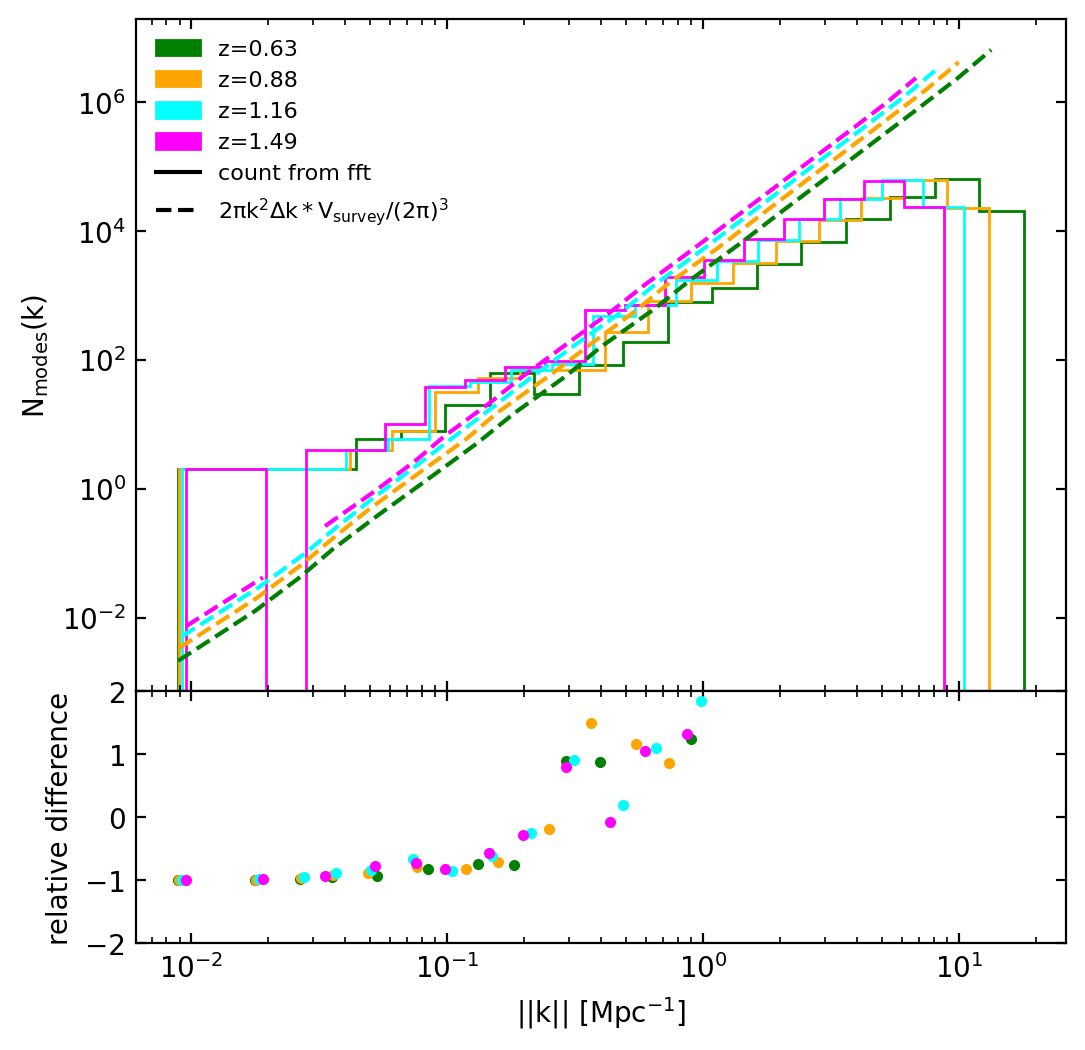

In [11]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, (ax, axr) =  plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,1.5]}, 
                                 figsize=(6,6), dpi = 200)
patchs = []
for i, (z,Zrad,res_quarter, sizequarter, resrad, c) in enumerate(zip( zquarters, Z_rad_quarters,res_transverse_quarters, size_quarters, res_radial_quarters, ('g', 'orange',  'cyan', 'magenta'))): 

    patch = mpatches.Patch(color=c, label=f'z={np.round(z.mean(),2)}' ); patchs.append(patch)
    #----------------------
    Kmaps = []
    
    for j in range(35):
        res = res_quarter[j]
        kmap = 2*np.pi*give_map_spatial_freq(res*u.rad, Z.shape[1], Z.shape[2])
        Kmaps.append(kmap)
        viz.plot((np.pi / res,  np.pi / res), (1.1-0.02,1.1+0.02), c='g',lw=1)
        viz.plot((2 * np.pi / lenght, 2 * np.pi / lenght),(1.1-0.02,1.1+0.02), c='g',lw=1)

    Kmaps = np.asarray(Kmaps)
    resz = resrad.mean()
    kz = 2*np.pi*give_map_spatial_freq_one_axis(resz, len(resrad))

    kz_arr = np.zeros(np.asarray(Kmaps).shape)
    kz_arr[:,:,:] = kz[:,np.newaxis, np.newaxis]
    k = np.sqrt(np.asarray(Kmaps)**2+kz[:,np.newaxis, np.newaxis]**2)/u.Mpc
    #Setting the binning of the k map
    k_binsnp = np.logspace(np.log10(k[k>0].min().value), np.log10(k.max().value), 20)
    #----------------------
    
    #Setting the binning of the k map
    nmodes, kbins = np.histogram(k, bins = k_binsnp/u.Mpc)
    kmean, kbins = np.histogram(k, bins = k_binsnp/u.Mpc, weights=k)
    kmean /= nmodes
    ax.stairs(nmodes,k_binsnp, color=c)

    Vtot = 4/3*np.pi*(cosmo.comoving_distance(z.max())**3-cosmo.comoving_distance(z.min())**3)
    Vsurvey =  (field_size*u.deg**2).to(u.sr) * Vtot / (4*np.pi)
    Nmodes = 2 * np.pi * kmean**2 * np.diff(k_binsnp) * Vsurvey / (2*np.pi)**3
    ax.plot(kmean, Nmodes, color=c, ls='--')
    axr.plot(kmean, ((Nmodes/nmodes).value -1), 'o',c=c,markersize=3)
    print(((Nmodes/nmodes).value -1))
    axr.set_ylabel('relative difference')
    axr.set_ylim(-2, 2)
    #ax.plot(kmean, Nmodes/4e3, color=c, ls=':')

patch = mlines.Line2D([], [], color='k', linestyle="solid",label='count from fft' ); patchs.append(patch);
patch = mlines.Line2D([], [], color='k', linestyle="--",label='$\\rm 2 \\pi k^2 \\Delta k *V_{survey} / (2\\pi)^3$' ); patchs.append(patch);
#patch = mlines.Line2D([], [], color='k', linestyle=":",label='$\\rm 2 \\pi k^2 \\Delta k *V_{survey} / (2\\pi)^3/4e3$' ); patchs.append(patch);

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$\\rm N_{modes}(k)$')
ax.legend(loc='upper left',handles = patchs, fontsize=8)
fig.subplots_adjust(hspace=0, wspace=0)
axr.set_xlabel(r'$\rm ||k||$ [$\rm Mpc^{-1}$]')
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})